# Baltimore City Crime Analysis

Baltimore Crime Data: https://data.baltimorecity.gov/datasets/baltimore::part-1-crime-data-/explore               
Baltimore shape file: https://data.imap.maryland.gov/datasets/maryland::maryland-baltimore-city-neighborhoods/about

   Growing up in the state of Maryland, the excess of crime that occurs in Baltimore covers most news cycles in the local region. As a data scientist, I want to explore trends in crime within the city of Baltimore, and perhaps uncover trends in crime occurance based on inceident based reporting data kept by the city of Baltimore. This notebook details a few ways of bringing the incident based data to life using the folium package, building out interactive marker cluster maps and heat maps.
    
   The crime data source is a frequently updated database of all crime incidents that occur within the city, with attributes for time of day, crime type and location.
    
   This analysis explores the visualization of this data, cultminating with an implementation of choropleth map that iterates through time. A tool like this could ideally be used to identify problem areas for various types of crime, understanding the geopgraphical lay out of different crime types across the city.


In [1]:
import pandas as pd
import numpy as np
import folium
import datetime as dt
import plotly.express as px

First, we read in the data, exploring some of the features. The observations represent specific crime incidents within Baltimore.

In [5]:
crime = pd.read_csv('Part_1_Crime_Data_.csv')
crime.head()

,X,Y,RowID,CrimeDateTime,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,...,Ethnicity,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,VRIName,Total_Incidents,Shape
0,-76.5404,39.3141,1,2022/08/13 05:00:00+00,3CF,6500 FRANKFORD AVE,ROBBERY - COMMERCIAL,NaN,HANDGUN,441,...,UNKNOWN,NORTHEAST,PULASKI INDUSTRIAL AREA,39.3141,-76.5404,"(39.3141,-76.5404)",NaN,NaN,1,NaN
1,-76.5704,39.2925,2,2022/08/13 05:20:00+00,4E,3300 E BALTIMORE ST,COMMON ASSAULT,NaN,PERSONAL_WEAPONS,222,...,HISPANIC_OR_LATINO,SOUTHEAST,PATTERSON PARK NEIGHBORHOOD,39.2925,-76.5704,"(39.2925,-76.5704)",NaN,NaN,1,NaN
2,-76.5704,39.2925,3,2022/08/13 05:20:00+00,5A,3300 E BALTIMORE ST,BURGLARY,NaN,PERSONAL_WEAPONS,222,...,HISPANIC_OR_LATINO,SOUTHEAST,PATTERSON PARK NEIGHBORHOOD,39.2925,-76.5704,"(39.2925,-76.5704)",NaN,NaN,1,NaN
3,-76.6045,39.2357,4,2022/08/13 06:00:00+00,4C,3700 5TH ST,AGG. ASSAULT,NaN,UNKNOWN,913,...,UNKNOWN,SOUTHERN,BROOKLYN,39.2357,-76.6045,"(39.2357,-76.6045)",NaN,Brooklyn,1,NaN
4,-76.6387,39.2846,5,2022/08/13 13:18:20+00,5A,1300 MCHENRY ST,BURGLARY,NaN,NaN,935,...,NaN,SOUTHERN,NEW SOUTHWEST/MOUNT CLARE,39.2846,-76.6387,"(39.2846,-76.6387)",NaN,Tri-District,1,NaN


After some basic data manipulation to format the dates and subset to necessary columns, we discover that the data set is incomplete for 2010 and prior years. Subsequently, we remove those incomplete years form the data. Some more data manipulation is performed to properly format the data for the visualizations.

In [6]:
crime_baltimore = crime.copy()
crime_baltimore = crime_baltimore[['CrimeDateTime','Description','Neighborhood','Latitude','Longitude']].dropna()
crime_baltimore = crime_baltimore.rename(columns = {'CrimeDateTime': 'DATE', 'Description': 'TYPE', 'District': 'DISTRICT', 'Neighborhood': 'NEIGHBORHOOD','Latitude': 'LAT','Longitude':'LON'})
crime_baltimore['YEAR'] = crime_baltimore['DATE'].str[:4].astype(int)
crime_baltimore = crime_baltimore[crime_baltimore['YEAR'] > 2000]
crime_baltimore['YEAR'].value_counts() # reporting system looks to have changed in 2010

2017    52183
2011    48632
2016    48582
2018    48483
2013    48017
2015    47977
2012    47819
2019    46498
2014    45129
2021    37229
2020    36201
2022    23407
2010       27
2009       15
2002       13
2008       12
2007       12
2001       11
2004        5
2003        4
2006        3
2005        3
Name: YEAR, dtype: int64

In [7]:
crime_baltimore = crime_baltimore[(crime_baltimore['YEAR'] > 2010) & (crime_baltimore['YEAR'] < 2022)]
crime_baltimore['DATE'] = crime_baltimore['DATE'].str[:10].astype('datetime64[ns]')
crime_baltimore = crime_baltimore.sort_values('DATE').reset_index(drop=True)
crime_baltimore['DATE'] = pd.to_datetime(crime_baltimore['DATE'], format = '%Y-%m-%d')
crime_baltimore['DATE'] = crime_baltimore['DATE'].dt.year
crime_baltimore = crime_baltimore[['DATE','TYPE','NEIGHBORHOOD']].reset_index()
crime_baltimore = crime_baltimore.groupby(['DATE','NEIGHBORHOOD', 'TYPE'])['index'].count().reset_index()
crime_baltimore = crime_baltimore.pivot(index = ['DATE', 'NEIGHBORHOOD'], columns = 'TYPE', values  ='index').reset_index().fillna(0)

crime_baltimore.head()

TYPE,DATE,NEIGHBORHOOD,AGG. ASSAULT,ARSON,AUTO THEFT,BURGLARY,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,ROBBERY - RESIDENCE,ROBBERY - STREET,SHOOTING
0,2011,ABELL,7.0,0.0,9.0,19.0,13.0,0.0,28.0,5.0,1.0,0.0,3.0,1.0,6.0,0.0
1,2011,ALLENDALE,29.0,0.0,34.0,45.0,35.0,0.0,30.0,29.0,1.0,0.0,1.0,2.0,11.0,0.0
2,2011,ARCADIA,10.0,0.0,5.0,22.0,19.0,0.0,11.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2011,ARLINGTON,29.0,2.0,9.0,38.0,46.0,0.0,27.0,6.0,2.0,0.0,3.0,4.0,9.0,0.0
4,2011,ARMISTEAD GARDENS,17.0,2.0,22.0,57.0,58.0,0.0,51.0,14.0,2.0,0.0,2.0,2.0,7.0,0.0


In [8]:
import json
with open('Maryland_Baltimore_City_Neighborhoods.geojson') as f:
    geojson = json.load(f)

In [11]:
crime = 'larceny'
crime = crime.upper()
data = crime_baltimore[['DATE','NEIGHBORHOOD',crime]]

# file becomes too large to push to github upon the creation of the figure

# fig = px.choropleth_mapbox(
#     data, geojson=geojson, 
#     locations='NEIGHBORHOOD', 
#     featureidkey = 'properties.NBRDESC',                           
#     color='LARCENY',                           
#     range_color = (0,100),                           
#     color_continuous_scale="Viridis",                           
#     mapbox_style="carto-positron",                           
#     zoom=11,                            
#     center = {"lat": 39.3, "lon": -76.6},                           
#     animation_frame = 'DATE'                          
# )
# fig.show()
# fig.write_html('larceny_year_counts_choropleth.html')

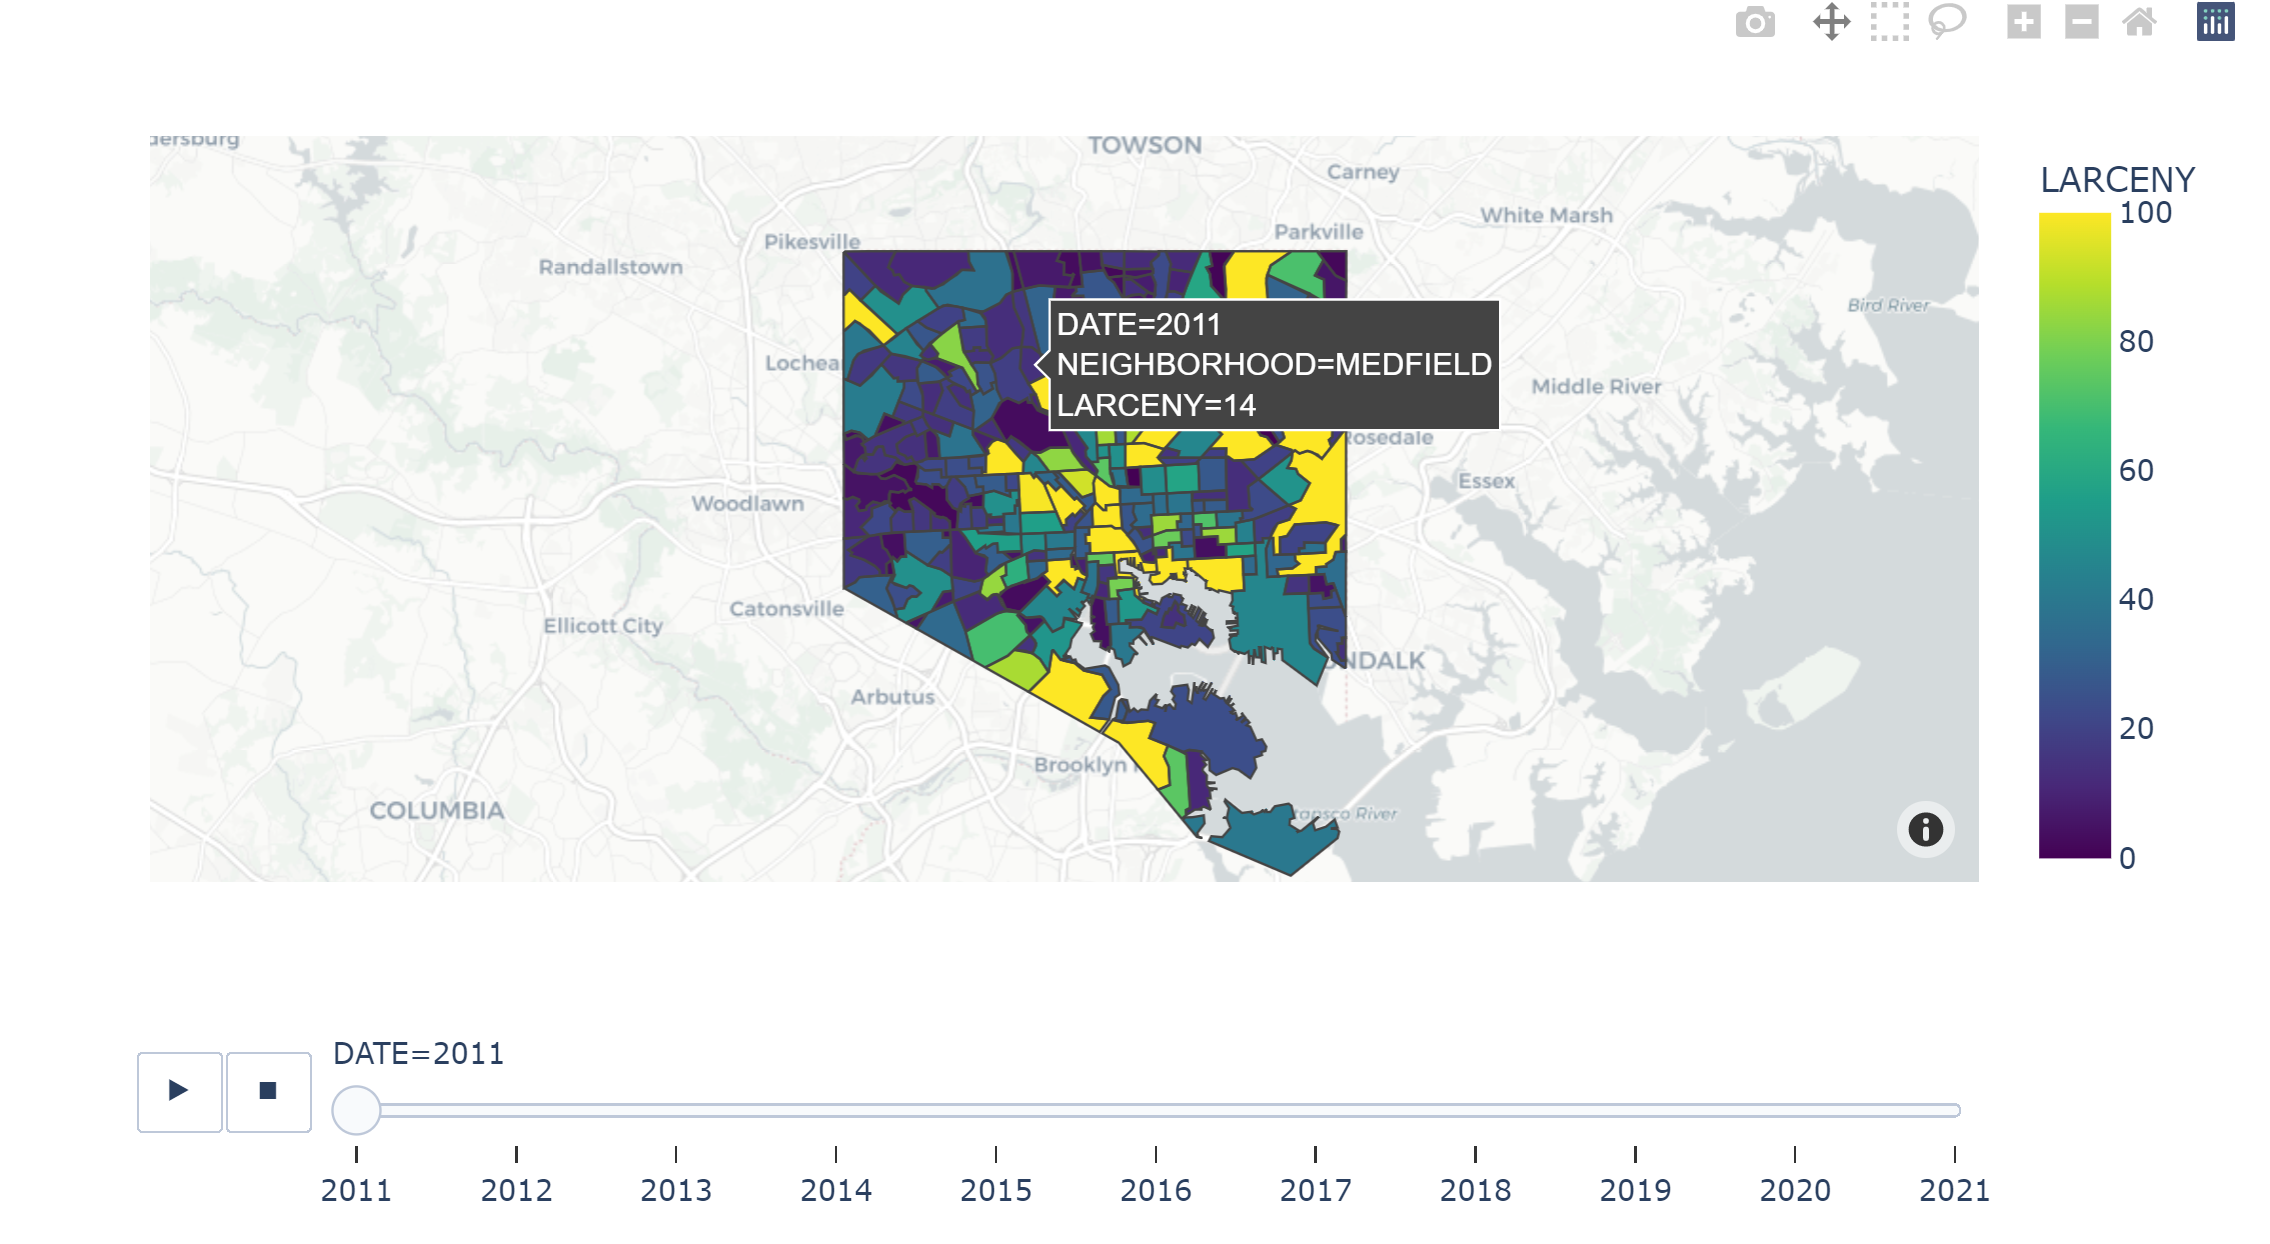